### Problem1

In [30]:
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd
import neptune

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

(b) Load the MNIST data (introduced in Chapter 3), and split it into a training set, a validation
set, and a test set (e.g., use 50,000 instances for training, 10,000 for validation, and 10,000
for testing). Then train various classifiers, such as a Random Forest classifier, and ExtraTrees classifier, and an SVM classifier. Next, try to combine them into an ensemble that
outperforms each individual classifier on the validation set, using soft or hard voting. Once
you have found one, try it on the test set.

In [2]:
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target']
y = y.astype(int)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10000, random_state=42)

In [4]:
rnd_clf = RandomForestClassifier()
ext_clf = ExtraTreesClassifier()
svm_clf = SVC(probability=True)

hvoting_clf = VotingClassifier(
    estimators=[('rf', rnd_clf), ('et', ext_clf), ('svc', svm_clf)],
    voting='hard')

svoting_clf = VotingClassifier(
    estimators=[('rf', rnd_clf), ('et', ext_clf), ('svc', svm_clf)],
    voting='soft')

In [6]:
for clf in (hvoting_clf, svoting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    print(clf.__class__.__name__, accuracy_score(y_val, y_pred))

VotingClassifier 0.9748
VotingClassifier 0.9749


In [8]:
y_pred = svoting_clf.predict(X_test)
print(f'soft voting clf :', accuracy_score(y_test, y_pred))

soft voting clf : 0.9717


(c)  Run the individual classifiers from the previous exercise to make predictions on the
validation set, and create a new training set with the resulting predictions: each training
instance is a vector containing the set of predictions from all your classifiers for an image,
and the target is the image’s class. Train a classifier on this new training set. Now evaluate
the ensemble on the test set. For each image in the test set, make predictions with all your
classifiers, then feed the predictions to the blender to get the ensemble’s predictions

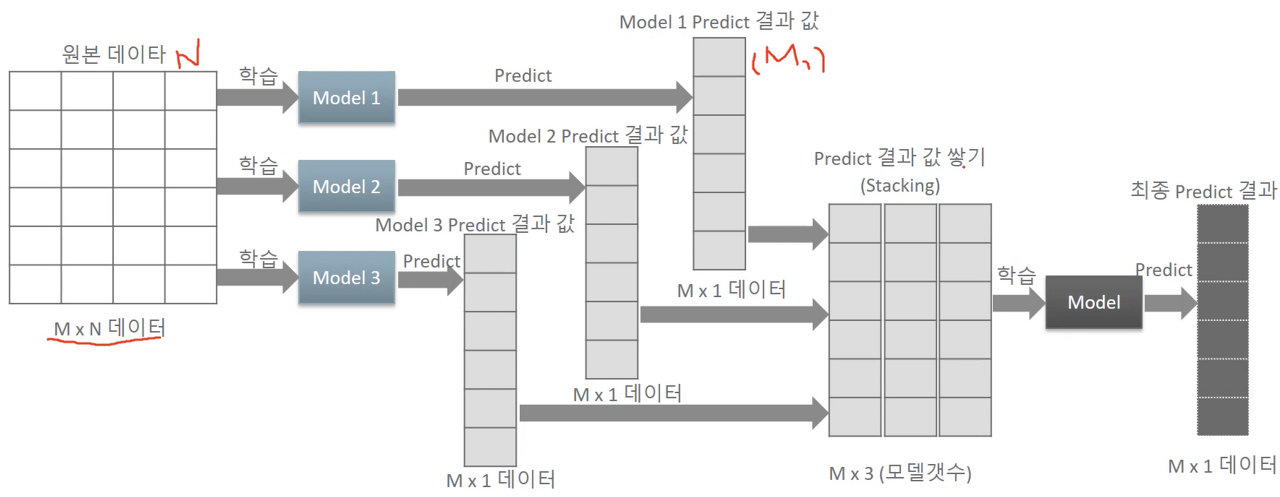

In [25]:
meta = np.empty((len(X_val), 3))

for i, clf in enumerate((rnd_clf, ext_clf, svm_clf)):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    meta[:, i] = y_pred

blend_clf = RandomForestClassifier(oob_score=True)
blend_clf.fit(meta, y_val)

NameError: name 'blend' is not defined

In [26]:
print(blend_clf.oob_score_)

0.975


In [27]:
data = np.empty((len(X_test), 3))

for i, clf in enumerate((rnd_clf, ext_clf, svm_clf)):
    y_pred = clf.predict(X_test)
    data[:, i] = y_pred

C:\Users\tasty\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


ValueError: X has 784 features, but RandomForestClassifier is expecting 3 features as input.

In [28]:
y_pred = blend_clf.predict(data)
print(accuracy_score(y_test, y_pred))

0.9709


In [31]:
from sklearn.ensemble import StackingClassifier

stack_clf = StackingClassifier(
    estimators=[('rf', rnd_clf), ('et', ext_clf), ('svc', svm_clf)],
    final_estimator = RandomForestClassifier())

(d) Train and fine-tune a Decision Tree for the moons dataset by following these steps:  
a. Use make_moons(n_samples=10000, noise=0.4) to generate a moos dataset.  
b. Use train_test_splist() to split the dataset into a training set and test set.  
c. Use grid search with cross-validation (with the help of the GridSearchCV class) to find
good hyperparameter values for a DecisionTreeClassifier. (Try various values for
max_leaf_nodes)  
d. Train it on the full training set using these hyperparameters, and measure your model’s
performance on the test set.

In [52]:
from sklearn.datasets import make_moons
from sklearn.model_selection import GridSearchCV

X, y = make_moons(n_samples=10000, noise=.4, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)

In [53]:
from sklearn.tree import DecisionTreeClassifier

In [54]:
param_grid = [{'max_depth' : [2,4,6,8,10], "max_leaf_nodes":[5,7,10,12,15,20,25,30]}]

tree_clf = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(tree_clf, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid=[{'max_depth': [2, 4, 6, 8, 10],
                          'max_leaf_nodes': [5, 7, 10, 12, 15, 20, 25, 30]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [55]:
grid_search.best_params_

{'max_depth': 8, 'max_leaf_nodes': 25}

In [56]:
tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_test)

print(accuracy_score(y_pred, y_test))

0.8145


In [57]:
best_clf = DecisionTreeClassifier(**grid_search.best_params_)
best_clf.fit(X_train, y_train)
y_pred = best_clf.predict(X_test)

print(accuracy_score(y_pred, y_test))

0.872


### Problem2

In [118]:
from sklearn.datasets import load_iris

raw = load_iris()

In [123]:
df = pd.DataFrame(data=raw.data, columns=raw.feature_names)
temp = pd.DataFrame(data=raw.target, columns=['label'])
df = pd.concat([df,temp],axis=1)

In [146]:
class TreeGenerate():
    def __init__(self, df):
        self.X = df.loc[:'label'].iloc[:,:-2]
        self.y = df.loc[:,'label']
        self.attr = list(df.columns.drop('label'))
        self.tree = {}
        
    def _screener(self):
        if np.unique(self.y).shape[0] == 1:
            return {'null':np.unique(y)[0]}
        if len(self.attr) == 0
            return {'null':np.max(df.loc[:,'label'])}    
    
    def _count_label(self):
        count = {}
        for i in self.y:
            if i not in count.keys():
                count[i] = 0
            count[i] += 1
        return count
    
    def _calculate_gini(self):
        gini = 1.
        count = self._count_label()
        for i in count.keys():
            p = count[i]/len(self.X)
            gini -= p**2
        return gini
    
    def _calculate_entropy(self, attr):
        elem, count = np.unique(attr, return_counts = True)
        entropy = -np.sum([(count[i]/np.sum(count))*np.log2(count[i]/np.sum(count)) for i in range(len(elem))])
        return entropy
    
    def _calculate_infogain(self, attr):
        
    def fit(self):
        self._screener()
        return self.tree

SyntaxError: invalid syntax (4172993425.py, line 11)